# How to Improve Finite Difference Approximation of a Continuos Geometry #

One key disadvantage to using FDFD is the messiness associated with approximating a continuous geometry using equally spaced chunks. To attempt this we can lean further into the analogy with pixels of a bitmap image. I think the formal scientific term for this is the interpolation/extrapolation method.

Let’s model a directional coupler consisting of two silica fibres in air to demonstrate how the PILLOW library can be used to do the work for you.  




In [6]:
import os 
# comment out this line if you installed philsol with pip
os.chdir('../')

import philsol as ps
from philsol.classy import phil_class
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cst
from matplotlib import cm 




It can be useful to define the refractive index using Sellmeier's equation

In [7]:
def refractive(lam):
    #Lets calculate the refractive index for fused silica
    
    B1 = 0.6961663
    B2 = 0.4079426
    B3 = 0.8974794
    C1 = 0.0684043**2
    C2 = 0.1162414 **2
    C3 = 9.896161**2
            
    n_square = ( 1  +  B1 * lam**2 / (lam**2 - C1) 
                    +  B2 * lam**2 / (lam**2 - C2) 
                    +  B3 * lam**2 / (lam**2 - C3) )
    
    return n_square**0.5 

Let's make a function to implement the coupler using hard pixels. We will also use the mirror symmetry of the problem to make our life slightly easier.

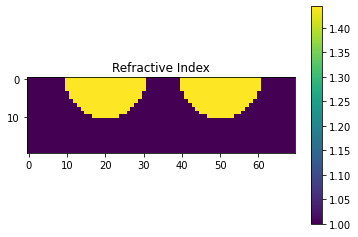

In [54]:
from PIL import ImageDraw, ImageFilter

def coupler_no_interp(lam, R, D, dx):
    
    radius = int(R / dx)
    pitch = int(D / dx)

    num_x = 6 * radius + pitch 
    num_y = 2 * radius 
    
    # Create greyscale bitmap with minimum value of 1 (refractive index of air)  
    geom = Image.new('F', (num_x, num_y), 1.) 
    geom_draw = ImageDraw.Draw(geom)
    geom_draw.ellipse([radius, -radius, 3*radius, radius], refractive(lam))
    geom_draw.ellipse([3*radius + pitch, -radius, 5*radius + pitch ,radius], refractive(lam))

    n = np.asarray(geom.getdata(), dtype = np.float64).reshape((num_y, num_x))
    n = n.transpose()
    
    return np.repeat(n[:,:,np.newaxis],3, axis = 2) 


plt.title('Refractive Index')
plt.imshow(coupler_no_interp(1.55, .5, .5, .5 /10.)[:,:,2].transpose())
plt.colorbar()


Looks awful! But let's still solve for the modes. This is a classic two level/Rabi system so we expect a symmetric/antisymmetric pair of modes.

Assembling matrix for 400 grid points...

and we are done (after 0.05636930465698242 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.009519100189208984 secs later we have the final solution.


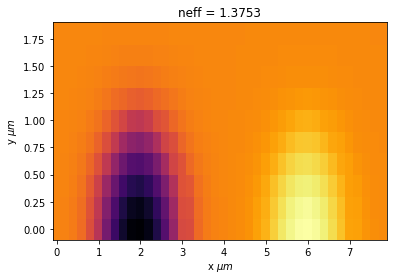

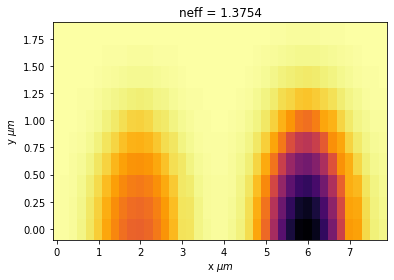

In [55]:
lam = 1.55
radius = 1. # 1 micron radius 
pitch = 2. # pitch (seperation between fibres)
dr = .2 # size of descretisation
k  = 2 * cst.pi / lam 


# Lets use classy to handle some of the messyness 
n = coupler_no_interp(lam, radius, pitch, dr)
supermodes = phil_class(n, k, dx = dr, dy = dr)
supermodes.build_stuff()
supermodes.solve_stuff(2, 1.4*k)




for i in range(2): 
    plt.figure()
    plt.title('neff = {:4.5}'.format(abs(supermodes.beta[i]/k)))
    E = np.reshape(supermodes.Ex[i,:], [supermodes.num_y, supermodes.num_x]) 
    plt.pcolormesh(supermodes.x, supermodes.y, E.real, shading = 'auto', cmap = 'inferno')
    plt.xlabel(r'x $\mu m$')
    plt.ylabel(r'y $\mu m$') 


We can see already that our solution isn't super accurate from the way the right hand mode has greater amplitude than the left one. There are several problems here:
1) a staircase isn't a very good representation of a curve

2) Rounding error from the discretisation being a similar order of magnitude to the pitch and radius

3) discretisation is too large to accurately sample the field (fdfd error)

We can do a convergence test by sweeping the size of the discretisation dr. We will also sweep the pitch to illustrate the rounding error. This might take a few minutes to run.
 

In [53]:
#print(dr)

# lets descretise 
dr_sweep = radius / np.linspace(5, 40, 5)
pitch_sweep = np.linspace(0, 1, 10)


neff_sweep = []
for p in pitch_sweep:
    _ = []
    for dr in dr_sweep:
        n = coupler_no_interp(lam, radius, p, dr)
        supermodes = phil_class(n, k, dx = dr, dy = dr)
        supermodes.build_stuff()
        supermodes.solve_stuff(2, 1.4*k)
        _.append(supermodes.beta/k)
    neff_sweep.append(_)

neff_sweep = np.array(neff_sweep)  

#print(np.shape(n))    
#plt.pcolormesh(np.reshape(Ex, np.flip(np.shape(n)[:2]).real))
               


5
0
Assembling matrix for 300 grid points...

and we are done (after 0.05083942413330078 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.015225410461425781 secs later we have the final solution.
13
0
Assembling matrix for 2028 grid points...

and we are done (after 0.10686802864074707 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.04283738136291504 secs later we have the final solution.
22
0
Assembling matrix for 5808 grid points...

and we are done (after 0.6516783237457275 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.11032390594482422 secs later we have the final solution.
31
0
Assembling matrix for 11532 grid points...

and we are done (after 2.311249256134033 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.4174232482910156 secs later we have the final solution.
40
0
Assembling matrix for 19200 grid points...

and we are done (after 6.055092096328735 secs).
Remember to build with 

and we are done (after 0.8955891132354736 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.12801337242126465 secs later we have the final solution.
31
24
Assembling matrix for 13020 grid points...

and we are done (after 3.231372833251953 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.4499242305755615 secs later we have the final solution.
40
31
Assembling matrix for 21680 grid points...

and we are done (after 8.924513101577759 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.9323873519897461 secs later we have the final solution.
5
4
Assembling matrix for 340 grid points...

and we are done (after 0.016355276107788086 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.006454944610595703 secs later we have the final solution.
13
12
Assembling matrix for 2340 grid points...

and we are done (after 0.2029428482055664 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.074

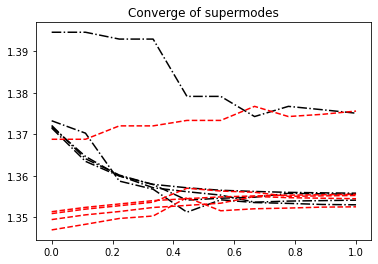

In [56]:
 
plt.figure()
plt.title('Converge of supermodes')
plt.plot(pitch_sweep, neff_sweep[:,:,0].real, '-.k')
plt.plot(pitch_sweep, neff_sweep[:,:,1].real,'--r')



So as expected as the descreetisation parameter is made smaller the solution converges onto a more and more accurate solution. The solution does not converge in a very smooth way tho as can be seen if we plot the solution for pitch = $1\mu m$. This is caused by a rounding error of the pitch. 

To improve on this we can draw the geometry using a more sophisticated function which uses anti-aliasing the curved boundaries.

(7000, 2000)
(70, 20)
(20, 70)


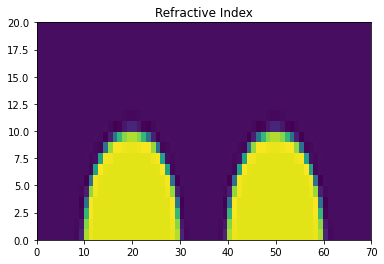

In [48]:
def coupler_interp(lam, R, D, dx):
    # parameter upscaling factor 
    scale = 100 
    dx_scaled = dx / float(scale)
        
    radius = int(R / dx_scaled)
    pitch = int(D / dx_scaled)
    # Lets 
    num_x = 6 * radius + pitch 
    num_y = 2 * radius 
    
    # Create greyscale bitmap with minimum value of 1 (refractive index of air)  
    geom = Image.new('F', (num_x, num_y), 1.) 
    geom_draw = ImageDraw.Draw(geom)
    geom_draw.ellipse([radius, -radius, 3*radius, radius], refractive(lam))
    geom_draw.ellipse([3*radius + pitch, -radius, 5*radius + pitch ,radius], refractive(lam))
    
    
    new_size = tuple([round(dim / scale) for dim in np.array(geom.size)])
    print(geom.size)
    print(new_size)
    
    #grom_R = geom.reduce(new_size, resample = Image.NEAREST)
    #geom_R = geom.resize(new_size, Image.BILINEAR)
    geom_R = geom.resize(new_size, Image.BICUBIC)

    #geom_R = geom.reduce(new_size)
    
    n = np.asarray(geom_R.getdata(), dtype = np.float64).reshape(np.flip(geom_R.size))
    n = n.transpose()
    
    return np.repeat(n[:,:,np.newaxis],3, axis = 2) 

n = coupler_interp(1.55, .5, .5, .5 /10.)[:,:,2].transpose()
print(np.shape(n))

plt.title('Refractive Index')
plt.pcolormesh(n)



In [49]:
# lets descretise 
dr_sweep = radius / np.linspace(5, 40, 5)
pitch_sweep = np.linspace(0, 1, 10)


neff_sweep_interp = []
for p in pitch_sweep:
    _ = []
    for dr in dr_sweep:
        n = coupler_interp(lam, radius, p, dr)
        supermodes = phil_class(n, k, dx = dr, dy = dr)
        supermodes.build_stuff()
        supermodes.solve_stuff(2, 1.4*k)
        _.append(supermodes.beta/k)
    neff_sweep_interp.append(_)

neff_sweep_interp = np.array(neff_sweep_interp)  

#print(np.shape(n))    

(3000, 1000)
(30, 10)
Assembling matrix for 300 grid points...

and we are done (after 0.014626741409301758 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.0057582855224609375 secs later we have the final solution.
(8250, 2750)
(82, 28)
Assembling matrix for 2296 grid points...

and we are done (after 0.12442874908447266 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.04632711410522461 secs later we have the final solution.
(13500, 4500)
(135, 45)
Assembling matrix for 6075 grid points...

and we are done (after 0.7007181644439697 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.13214492797851562 secs later we have the final solution.
(18744, 6248)
(187, 62)
Assembling matrix for 11594 grid points...

and we are done (after 2.306628942489624 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.4211101531982422 secs later we have the final solution.
(24000, 8000)
(240, 80)
Assembling matrix for

0.5507254600524902 secs later we have the final solution.
(3388, 1000)
(34, 10)
Assembling matrix for 340 grid points...

and we are done (after 0.01164102554321289 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.005155086517333984 secs later we have the final solution.
(9319, 2750)
(93, 28)
Assembling matrix for 2604 grid points...

and we are done (after 0.16820955276489258 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.049890756607055664 secs later we have the final solution.
(15249, 4500)
(152, 45)
Assembling matrix for 6840 grid points...

and we are done (after 0.9602236747741699 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.14468622207641602 secs later we have the final solution.
(21174, 6248)
(212, 62)
Assembling matrix for 13144 grid points...

and we are done (after 3.2439517974853516 secs).
Remember to build with extra matrices
Solving eigenmodes on CPU
0.44555068016052246 secs later we have the fi

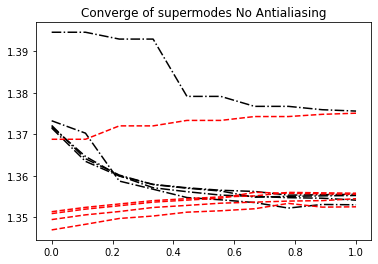

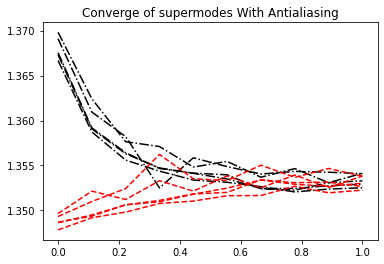

In [52]:
plt.figure()
plt.title('Converge of Supermodes No Antialiasing')
plt.plot(pitch_sweep, neff_sweep[:,:,0].real, '-.k')
plt.plot(pitch_sweep, neff_sweep[:,:,1].real,'--r')

plt.figure()
plt.title('Converge of Supermodes With Antialiasing')
plt.plot(pitch_sweep, neff_sweep_interp[:,:,0].real, '-.k')
plt.plot(pitch_sweep, neff_sweep_interp[:,:,1].real,'--r')



I'm not sure how conculsive these results are but they seem to help with the coarser descreetisations. 